In [18]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
sys.path.append("../Python_scripts")
from preprocess import pre_process
from export_anndata import export_anndata
from deg_enrichr import perform_deg_enrichment, plot_enrichment_barplot, plot_volcano
import numpy as np
import random
SEED = 0
np.random.seed(SEED)
random.seed(SEED)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
plt.rcParams["savefig.dpi"] = 300

from matplotlib.colors import LinearSegmentedColormap

my_cmap = LinearSegmentedColormap.from_list(
    "soft_rdbl", ["#4A90E2", "#D9D9D9", "#D0021B"], N=256
)

## Download sample dataset

In [5]:
%%bash
mkdir -p data write
cd data
test -f pbmc3k_filtered_gene_bc_matrices.tar.gz || curl https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -o pbmc3k_filtered_gene_bc_matrices.tar.gz
tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

## Read sample dataset

In [30]:
!tree data

data
├── filtered_gene_bc_matrices
│   └── hg19
│       ├── barcodes.tsv
│       ├── genes.tsv
│       └── matrix.mtx
└── pbmc3k_filtered_gene_bc_matrices.tar.gz

2 directories, 4 files


In [2]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols 
)

Before Pre-processing: 2700


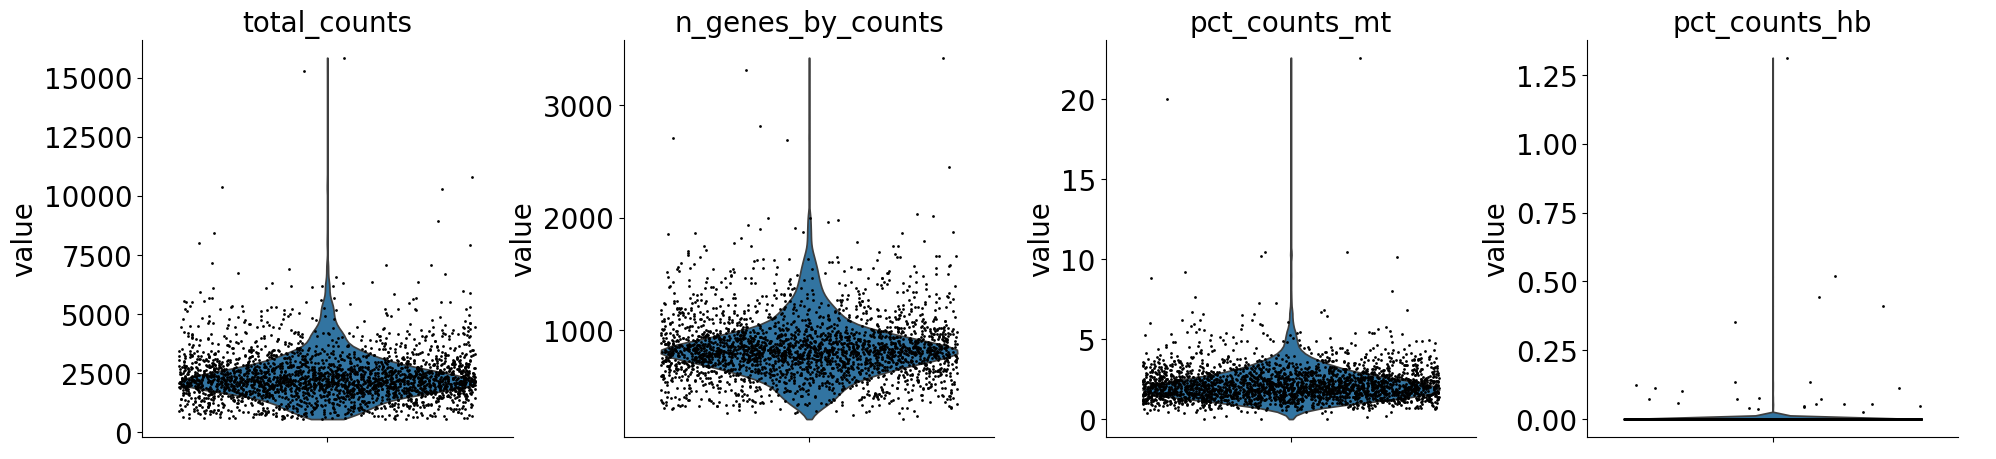

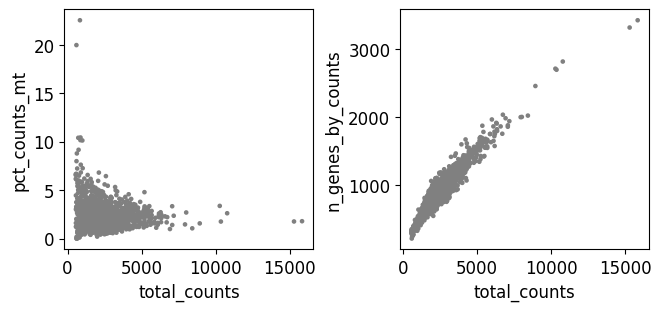

After filtering of low quality cells: 2638


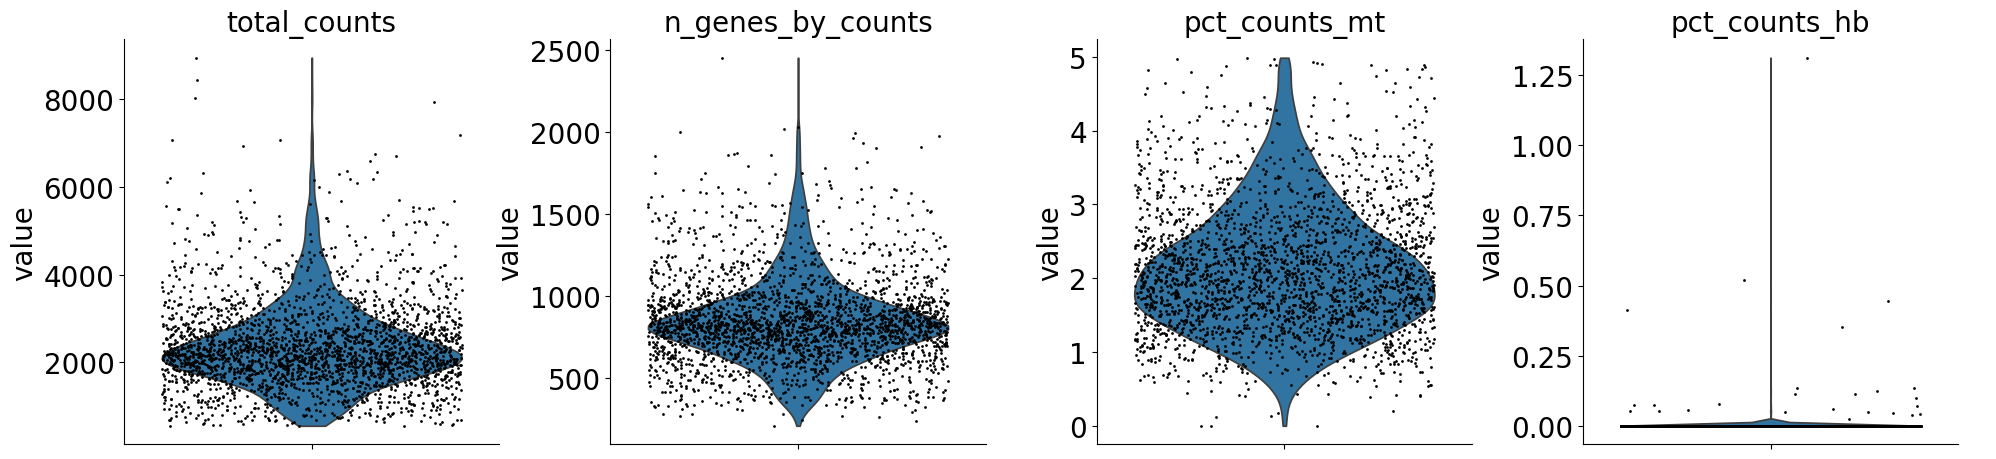

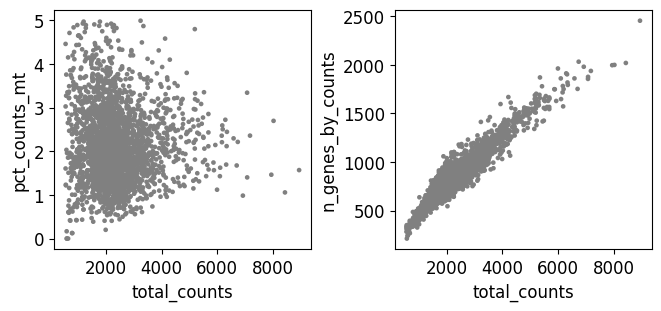

scDblFinder_class
singlet    2507
doublet     131
Name: count, dtype: int64
After filtering dobulet: 2507


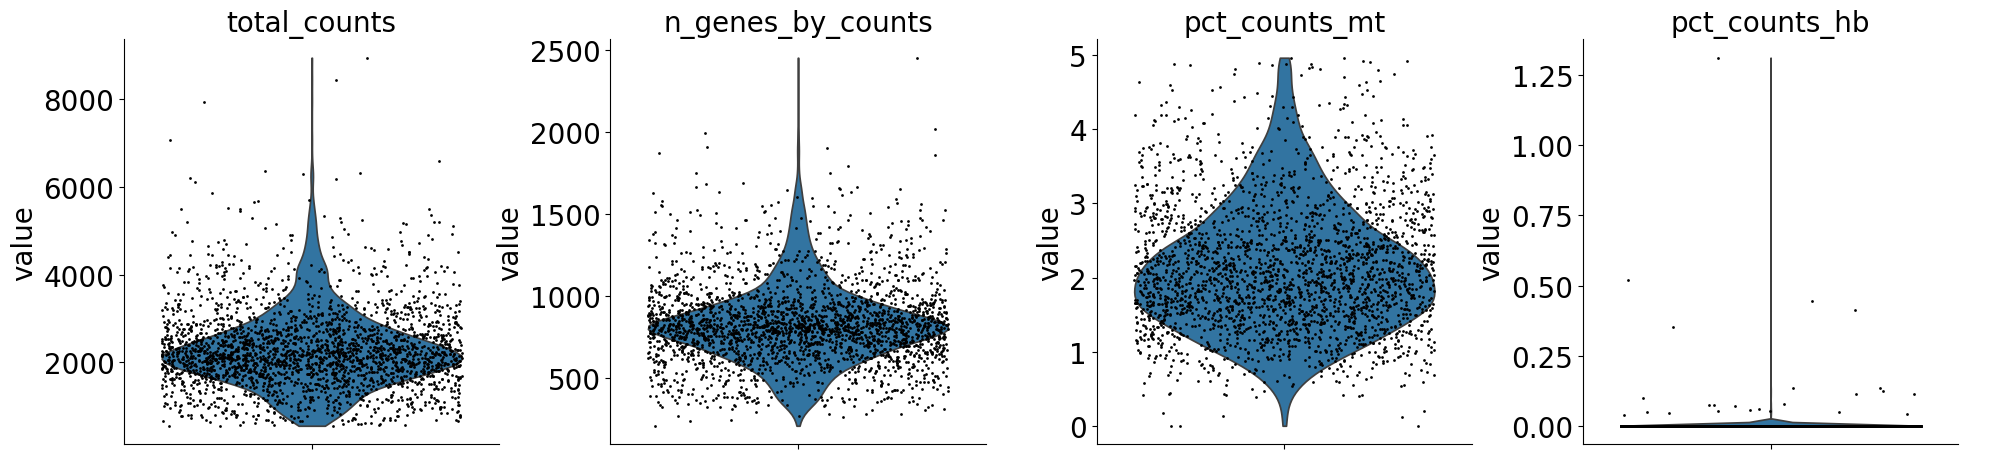

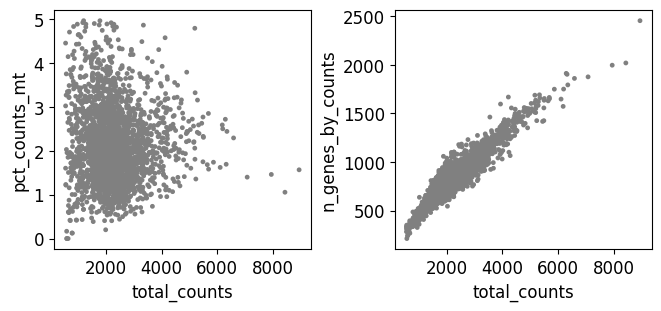

After Pre-processing: 2507


In [3]:
adata = pre_process(adata, seed=SEED, lo_lim_nfeature=200, up_lim_nfeature=2500, up_lim_mt=5, filter_doublets=True)

In [4]:
adata.write("write/preprocessed.h5ad")

## Normalization

In [6]:
adata = sc.read_h5ad("write/preprocessed.h5ad")

In [7]:
%%time
adata.layers["counts"] = adata.X.copy()

# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(
    adata,
    layer="counts",
    n_top_genes=2000, # or 3000 HVGs with larger dataset
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5,
    flavor="seurat_v3",
)

adata.layers["scaled"] = adata.X.toarray()
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"], layer="scaled")
sc.pp.scale(adata, max_value=10, layer="scaled")
adata

CPU times: user 3.53 s, sys: 259 ms, total: 3.79 s
Wall time: 801 ms


AnnData object with n_obs × n_vars = 2507 × 32738
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'scaled'

In [9]:
%%time
# PCA auto detect HVG
sc.pp.pca(adata, layer="scaled", svd_solver="arpack", random_state=SEED)
adata

CPU times: user 1.61 s, sys: 3.73 ms, total: 1.61 s
Wall time: 144 ms


AnnData object with n_obs × n_vars = 2507 × 32738
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'scaled'

In [ ]:
adata.write("write/normalized.h5ad")

In [31]:
!tree write

write
├── normalized.h5ad
└── preprocessed.h5ad

0 directories, 2 files


## UMAP and T-SNE, Clustering

In [11]:
adata = sc.read("write/normalized.h5ad")

In [12]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [13]:
sc.tl.umap(adata)

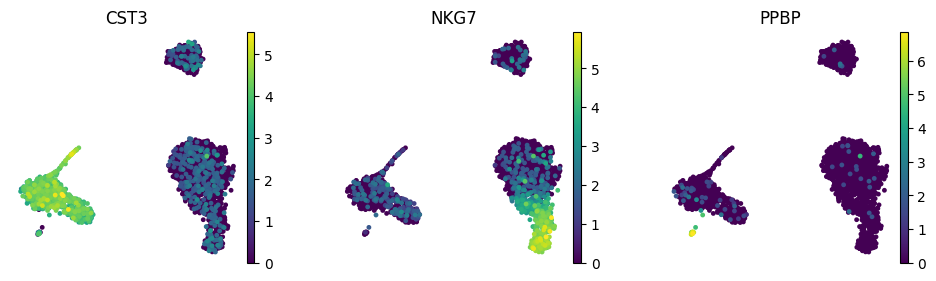

In [14]:
with plt.rc_context({'figure.figsize': (3, 3)}):
    sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], frameon=False)

In [15]:
sc.tl.tsne(adata)

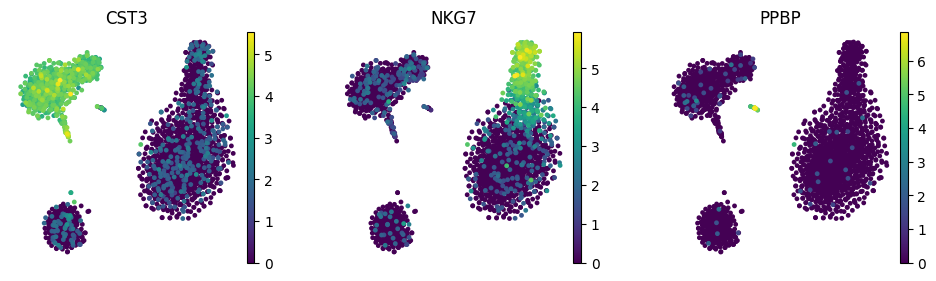

In [16]:
with plt.rc_context({'figure.figsize': (3, 3)}):
    sc.pl.tsne(adata, color=["CST3", "NKG7", "PPBP"], frameon=False)

In [23]:
sc.tl.leiden(
    adata,
    resolution=0.8,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

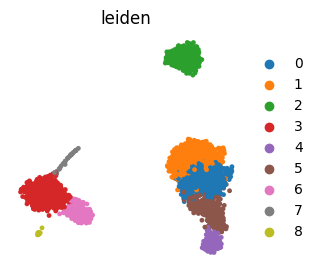

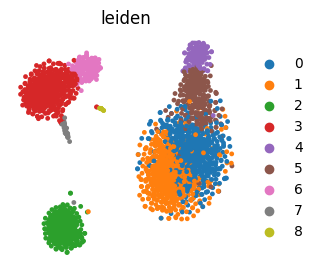

In [46]:
with plt.rc_context({'figure.figsize': (3, 3)}):
    sc.pl.umap(adata, color="leiden", frameon=False)
    sc.pl.tsne(adata, color="leiden", frameon=False)

In [61]:
marker_genes = {
    'CD4 T': ["IL7R"],
    'CD8 T': ["CD8A", "CD8B"],
    'B': ["CD79A", "MS4A1"],
    'NK': ["GNLY", "NKG7"],
    'FCGR3A+ Monocytes': ["FCGR3A"],
    'CD14+ Monocytes': ["CD14", 'LGALS3', 'S100A8'],
    'Dendritic cell': ["FCER1A", "CST3"],
    'Megakaryocyte': ["PPBP"],
}

Groups are not reordered because the `groupby` categories and the `var_group_labels` are different.
categories: 0, 1, 2, etc.
var_group_labels: CD4 T, CD8 T, B, etc.


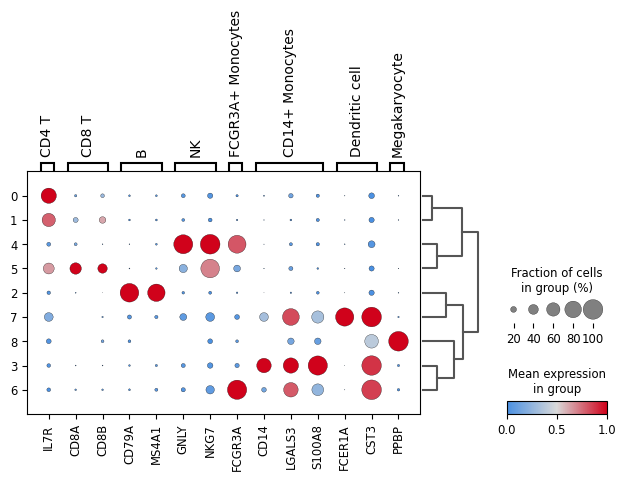

In [62]:
with plt.rc_context({'figure.figsize': (3, 3)}):
    sc.tl.dendrogram(adata, groupby="leiden", use_rep='X_pca')
    sc.pl.dotplot(adata, marker_genes, groupby="leiden", standard_scale='var', dendrogram=True, cmap=my_cmap)

In [ ]:
ct2id = {
    '0': 'CD4 T',
    '1': 'CD4 T',
    '2': 'B',
    '3': 'CD14+ Monocytes',
    '4': 'NK',
    '5': 'CD8 T',
    '6': 'FCGR3A+ Monocytes',
    '7': 'Dendritic cell',
    '8': 'Megakaryocyte'
}

adata.obs['cell_type'] = adata.obs['leiden'].map(ct2id)

# Set cell type order
adata.obs['cell_type'] = pd.Categorical(
    adata.obs['cell_type'],
    categories=['CD4 T', 'CD8 T', 'B', 'NK',  'FCGR3A+ Monocytes','CD14+ Monocytes', 'Dendritic cell', 'Megakaryocyte']
)

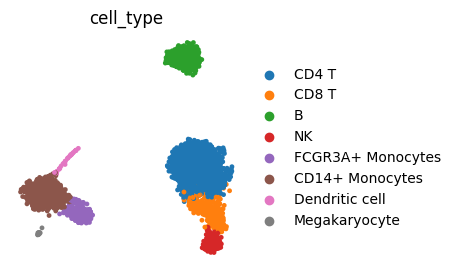

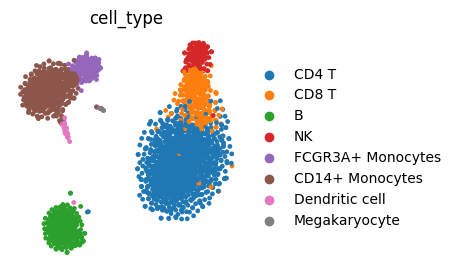

In [67]:
with plt.rc_context({'figure.figsize': (3, 3)}):
    sc.pl.umap(adata, color="cell_type", frameon=False)
    sc.pl.tsne(adata, color="cell_type", frameon=False)

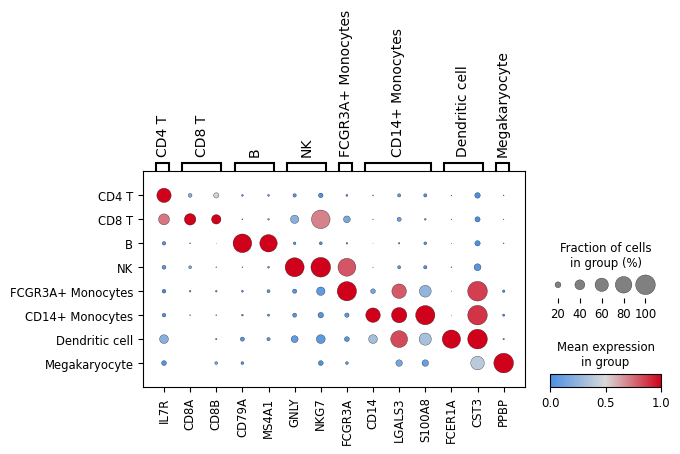

In [68]:
with plt.rc_context({'figure.figsize': (3, 3)}):
    sc.pl.dotplot(adata, marker_genes, groupby="cell_type", standard_scale='var', cmap=my_cmap)

In [70]:
adata.write("write/clustered.h5ad")
adata

AnnData object with n_obs × n_vars = 2507 × 32738
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'leiden', 'cell_type'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'tsne', 'leiden', 'leiden_colors', 'dendrogram_leiden', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    layers: 'counts', 'scaled'
    obsp: 'distances', 'connectivities'

## DEG, GSEA, Enrichr

In [19]:
adata = sc.read("write/clustered.h5ad")
adata

AnnData object with n_obs × n_vars = 2507 × 32738
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'leiden', 'cell_type'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scaled'
    obsp: 'connectivities', 'distances'

* 

In [20]:
reference_group, compare_group = 'the rest', 'CD8 T'

deg_df, pos_df, neg_df, gsea_df, pos_enr_df, neg_enr_df = perform_deg_enrichment(
    adata, annotation_column='cell_type',
    compare_group=compare_group, reference_group=reference_group,
    gene_sets='KEGG_2021_Human'
)

Performing differential expression analysis for cell_type...
CD8 T vs the rest


2026-02-05 12:44:23,817 [WARNING] Duplicated values found in preranked stats: 75.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2026-02-05 12:44:23,818 [INFO] Parsing data files for GSEA.............................
2026-02-05 12:44:23,857 [INFO] Enrichr library gene sets already downloaded in: /users/PAS2148/tiger/.cache/gseapy, use local file
2026-02-05 12:44:23,873 [INFO] 0001 gene_sets have been filtered out when max_size=1000 and min_size=5
2026-02-05 12:44:23,874 [INFO] 0319 gene_sets used for further statistical testing.....
2026-02-05 12:44:23,874 [INFO] Start to run GSEA...Might take a while..................
2026-02-05 12:44:41,663 [INFO] Congratulations. GSEApy runs successfully................



Enrichr criteria: pvals_adj < 0.05 & |logfoldchanges| > 0.5


### Volcano plot for DEGs

In [5]:
os.makedirs("plots", exist_ok=True)

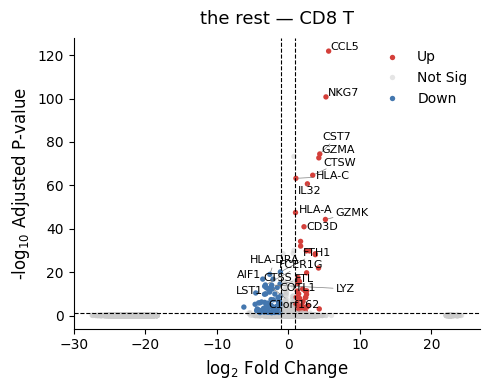

In [14]:
plot_volcano(
    deg_df,
    lfc_thr=1.0,
    padj_thr=0.05,
    title=f"{reference_group} — {compare_group}",
    show=True,
    figsize=(5, 4),
    save_path="plots/volcano.pdf"
)

### Enrichment barplot
NOTE: Enriched pathways for enrichr could have the same one in two directions.

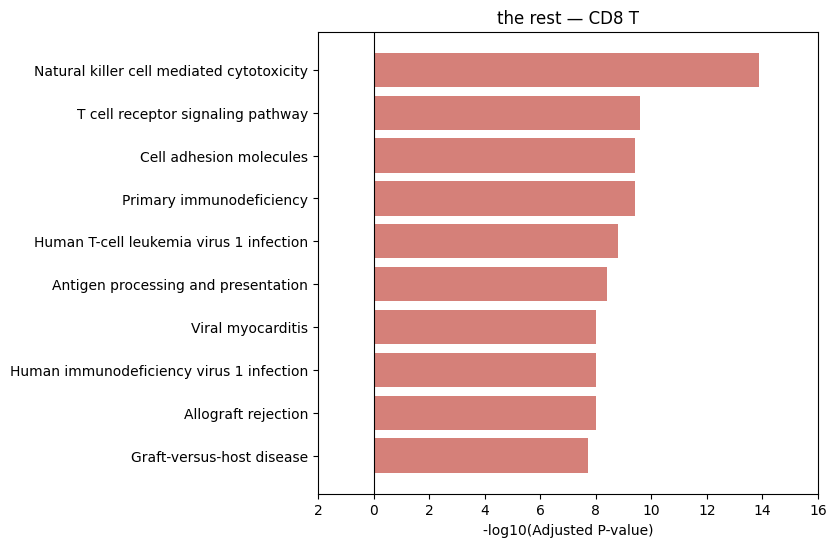

In [ ]:
plot_enrichment_barplot(
    pos_enr_df,
    top_n=10,
    save_path="plots/enrichment_pos_barplot.pdf",
    title=f"{reference_group} — {compare_group}",
    show=True
)

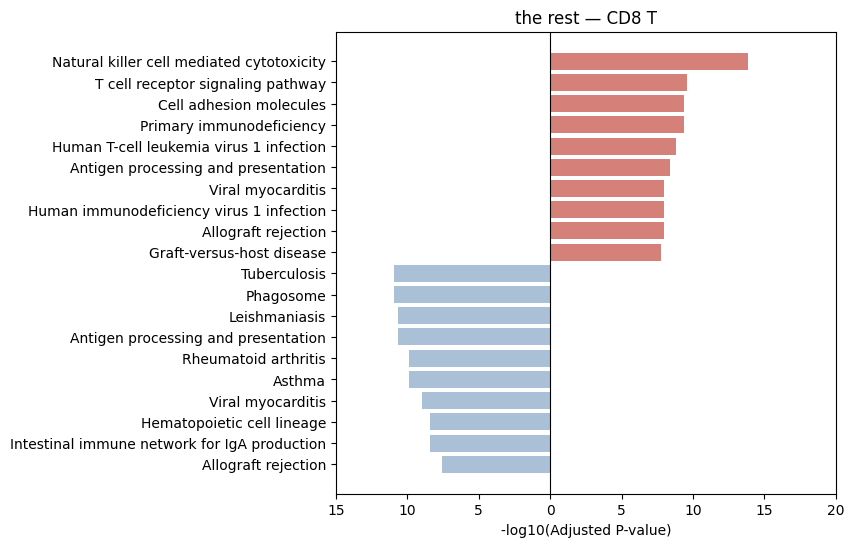

In [30]:
plot_enrichment_barplot(
    pos_enr_df,
    neg_enr_df,
    top_n=10,
    save_path="plots/enrichment_pos_neg_barplot.pdf",
    title=f"{reference_group} — {compare_group}",
    show=True
)

## Export anndata

In [71]:
export_anndata(adata, "export")

UMAP coordinates saved to export/umap_coordinates.csv
T-SNE coordinates saved to export/tsne_coordinates.csv
All files exported to export


In [23]:
!tree export

export
├── cells.csv
├── genes.csv
├── metadata.csv
├── norm_expr.mtx
├── raw_counts.mtx
├── tsne_coordinates.csv
└── umap_coordinates.csv

0 directories, 7 files
